In [92]:
import optuna
import xgboost as xgb
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import make_scorer, average_precision_score, roc_auc_score, classification_report
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [45]:

import pandas as pd
import numpy as np
import math
import ast
import sklearn
import time

import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm

In [4]:
merged_data = pd.read_csv('/content/shots_data_2015_25.csv')

In [5]:
merged_data

,Unnamed: 0,level_0,id,index,play_pattern,location,shot,possession_team,type,outcome,...,opp_in_box,gk_dist_from_goal,gk_dist_from_player,gk_x,gk_y,opponents_near,x,y,distance,angle
0,0,1,bbc2c68d-c096-483d-abf4-32c0175a0f55,480,Regular Play,"[114.6, 33.5]","{'statsbomb_xg': 0.14338115, 'end_location': [...",Bayer Leverkusen,Open Play,0,...,6.0,3.981206,4.701064,118.3,36.4,0.0,114.6,33.5,8.450444,37.941499
1,1,4,bb53b537-1685-4019-9e8f-98f3805828eb,848,Regular Play,"[89.2, 42.5]","{'statsbomb_xg': 0.021271583, 'end_location': ...",Bayer Leverkusen,Open Play,0,...,5.0,3.101612,27.803777,116.9,40.1,0.0,89.2,42.5,30.901294,14.704957
2,2,6,b6b96d19-97e3-4770-996a-f20696123abe,990,Regular Play,"[105.4, 45.1]","{'statsbomb_xg': 0.082292914, 'end_location': ...",Werder Bremen,Open Play,0,...,4.0,3.106445,12.472369,117.4,41.7,1.0,105.4,45.1,15.465122,27.626114
3,3,12,8cf6ed6f-59f8-455f-8930-f5b71f06c180,1696,Regular Play,"[113.1, 27.5]","{'statsbomb_xg': 0.07415738, 'end_location': [...",Bayer Leverkusen,Open Play,0,...,6.0,5.314132,9.069730,118.2,35.0,0.0,113.1,27.5,14.277955,16.374678
4,4,15,6db2523e-9343-461c-a8d6-b202470c1e0b,2573,Regular Play,"[97.5, 40.8]","{'statsbomb_xg': 0.048408102, 'end_location': ...",Werder Bremen,Open Play,0,...,2.0,2.236068,20.303941,117.8,40.4,0.0,97.5,40.8,22.514218,20.137024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20963,6,11,be0e299a-5792-4aed-bfe0-9d9d9145c097,2462,Regular Play,"[100.1, 31.7]","{'statsbomb_xg': 0.04493596, 'end_location': [...",Belgium,Open Play,0,...,6.0,2.831960,18.915602,117.9,38.1,0.0,100.1,31.7,21.561540,19.526781
20964,0,5,084939b5-a5d1-4ca5-a33c-9bc6132cddce,700,Regular Play,"[109.5, 43.3]","{'statsbomb_xg': 0.052362066, 'end_location': ...",Switzerland,Open Play,0,...,7.0,1.931321,9.080198,118.2,40.7,1.0,109.5,43.3,11.006362,38.622573
20965,1,7,852f7472-a3cf-4eda-969c-6c309236e306,901,Regular Play,"[102.7, 48.3]","{'statsbomb_xg': 0.110931315, 'end_location': ...",Switzerland,Open Play,0,...,6.0,2.420744,16.834488,118.1,41.5,0.0,102.7,48.3,19.188017,21.453877
20966,2,17,bbf61548-3506-4b1e-8f39-5f312907f01f,1888,Regular Play,"[108.2, 47.7]","{'statsbomb_xg': 0.100927465, 'end_location': ...",Wales,Open Play,0,...,6.0,2.000000,12.463146,118.0,40.0,0.0,108.2,47.7,14.090067,27.346887


In [6]:
merged_data.columns

Index(['Unnamed: 0', 'level_0', 'id', 'index', 'play_pattern', 'location',
       'shot', 'possession_team', 'type', 'outcome', 'body_part', 'players',
       'home_team', 'follows_dribble', 'teammates_in_box', 'teammates_ahead',
       'opp_in_box', 'gk_dist_from_goal', 'gk_dist_from_player', 'gk_x',
       'gk_y', 'opponents_near', 'x', 'y', 'distance', 'angle'],
      dtype='object')

In [46]:
#filter data to get only open play shots which are not headers
merged_data = merged_data[(merged_data['type']=='Open Play') & (merged_data['body_part']!='Head')]

In [47]:
data1 = merged_data[['location','outcome','home_team', 'teammates_in_box', 'teammates_ahead',
       'opp_in_box', 'gk_dist_from_goal', 'gk_dist_from_player', 'opponents_near','distance', 'angle']].reset_index(drop=True)

In [49]:
data1

,location,outcome,home_team,teammates_in_box,teammates_ahead,opp_in_box,gk_dist_from_goal,gk_dist_from_player,opponents_near,distance,angle
0,"[114.6, 33.5]",0,1,3.0,0.0,6.0,3.981206,4.701064,0.0,8.450444,37.941499
1,"[89.2, 42.5]",0,1,2.0,5.0,5.0,3.101612,27.803777,0.0,30.901294,14.704957
2,"[105.4, 45.1]",0,0,2.0,0.0,4.0,3.106445,12.472369,1.0,15.465122,27.626114
3,"[113.1, 27.5]",0,1,1.0,0.0,6.0,5.314132,9.069730,0.0,14.277955,16.374678
4,"[97.5, 40.8]",0,0,3.0,4.0,2.0,2.236068,20.303941,0.0,22.514218,20.137024
...,...,...,...,...,...,...,...,...,...,...,...
19226,"[93.1, 46.2]",0,0,1.0,3.0,1.0,2.012461,25.653460,0.0,27.605253,16.090339
19227,"[102.4, 23.6]",0,0,2.0,2.0,7.0,3.498571,20.717143,0.0,24.056600,14.047742
19228,"[100.1, 31.7]",0,1,3.0,3.0,6.0,2.831960,18.915602,0.0,21.561540,19.526781
19229,"[102.7, 48.3]",0,0,3.0,3.0,6.0,2.420744,16.834488,0.0,19.188017,21.453877


In [50]:
feature_columns = ['home_team', 'teammates_in_box', 'teammates_ahead',
                   'opp_in_box', 'gk_dist_from_goal', 'gk_dist_from_player',
                   'opponents_near', 'distance', 'angle']

X_train, X_test, y_train, y_test = train_test_split(
    data1[feature_columns],
    data1['outcome'],
    test_size=0.2,
    random_state=42,
    stratify=data1['outcome']
)

class_ratio = (y_train == 0).sum() / (y_train == 1).sum()

print(f"Dataset size: {X_train.shape[0]} training samples")
print(f"Features: {X_train.shape[1]}")
print(f"Class ratio: {class_ratio:.2f}")

Dataset size: 15384 training samples
Features: 9
Class ratio: 9.13


## Finetuning the paramters of lightgbm for best performance using optuna

In [52]:

def create_objective_function(X_train, y_train, class_ratio):
    """Create objective function for Optuna optimization"""
    
    def objective(trial):
        # XGBoost hyperparameters
        params = {
            'objective': 'binary:logistic',
            'verbosity': 0,
            'random_state': 42,
            'eval_metric': 'logloss',

            # Handle class imbalance
            'scale_pos_weight': class_ratio,

            # Tree structure parameters
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'min_child_weight': trial.suggest_float('min_child_weight', 0.1, 10, log=True),
            'gamma': trial.suggest_float('gamma', 0.0, 0.5)

            # Regularization parameters
            'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),  # L1 regularization
            'reg_lambda': trial.suggest_float('reg_lambda', 0.1, 2.0),  # L2 regularization

            # Sampling parameters
            'subsample': trial.suggest_float('subsample', 0.7, 1.0),  # Row sampling
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 1.0),  # Column sampling
            'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.7, 1.0),  # Column sampling per level

            # Learning parameters
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
            'n_estimators': trial.suggest_int('n_estimators', 50, 300),

            # XGBoost specific
            'grow_policy': trial.suggest_categorical('grow_policy', ['depthwise', 'lossguide']),
        }

        # If using lossguide, add max_leaves parameter
        if params['grow_policy'] == 'lossguide':
            params['max_leaves'] = trial.suggest_int('max_leaves', 10, 100)

        try:
            # Create model
            model = xgb.XGBClassifier(**params)

            # Use stratified cross-validation on training set only
            cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

            # Focus on PR-AUC for imbalanced data, but also consider ROC-AUC
            pr_scores = cross_val_score(model, X_train, y_train, cv=cv,
                                       scoring=make_scorer(average_precision_score))
            roc_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='roc_auc')

            # Combined objective: prioritize PR-AUC but consider both
            combined_score = 0.8 * pr_scores.mean() + 0.2 * roc_scores.mean()

            # Store additional metrics for analysis
            trial.set_user_attr('pr_auc_mean', pr_scores.mean())
            trial.set_user_attr('pr_auc_std', pr_scores.std())
            trial.set_user_attr('roc_auc_mean', roc_scores.mean())
            trial.set_user_attr('roc_auc_std', roc_scores.std())

            return combined_score

        except Exception as e:
            print(f"Trial failed: {e}")
            return 0.0  # Return poor score for failed trials

    return objective

In [54]:
# Create study
study = optuna.create_study(
    direction='maximize',
    sampler=optuna.samplers.TPESampler(seed=42),
    pruner=optuna.pruners.MedianPruner(n_startup_trials=10, n_warmup_steps=2),
    study_name='xgboost_soccer_optimization'
)

# Create objective
objective = create_objective_function(X_train, y_train, class_ratio)

n_trials = 200
print(f"Running {n_trials} optimization trials...")

study.optimize(objective, n_trials=n_trials, show_progress_bar=True)



[I 2025-08-09 18:10:49,651] A new study created in memory with name: xgboost_soccer_optimization


Running 200 optimization trials...


  0%|          | 0/200 [00:00<?, ?it/s]

[I 2025-08-09 18:10:54,722] Trial 0 finished with value: 0.3227655255740125 and parameters: {'max_depth': 5, 'min_child_weight': 7.969454818643936, 'gamma': 0.36599697090570255, 'reg_alpha': 0.5986584841970366, 'reg_lambda': 0.39643541684062933, 'subsample': 0.7467983561008608, 'colsample_bytree': 0.7174250836504598, 'colsample_bylevel': 0.9598528437324805, 'learning_rate': 0.06054365855469246, 'n_estimators': 227, 'grow_policy': 'lossguide', 'max_leaves': 85}. Best is trial 0 with value: 0.3227655255740125.
[I 2025-08-09 18:10:57,237] Trial 1 finished with value: 0.3296590464076012 and parameters: {'max_depth': 4, 'min_child_weight': 0.23102018878452935, 'gamma': 0.09170225492671691, 'reg_alpha': 0.3042422429595377, 'reg_lambda': 1.097037220101252, 'subsample': 0.8295835055926347, 'colsample_bytree': 0.7873687420594125, 'colsample_bylevel': 0.8835558684167139, 'learning_rate': 0.01518747922672247, 'n_estimators': 123, 'grow_policy': 'lossguide', 'max_leaves': 81}. Best is trial 1 with

In [93]:
print("\n=== OPTIMIZATION RESULTS ===")
print(f"Number of completed trials: {len([t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE])}")
print(f"Best combined score: {study.best_value:.4f}")

# Get best trial details
best_trial = study.best_trial
print(f"\nBest trial metrics:")
print(f"  PR-AUC: {best_trial.user_attrs.get('pr_auc_mean', 'N/A'):.4f} (±{best_trial.user_attrs.get('pr_auc_std', 0):.4f})")
print(f"  ROC-AUC: {best_trial.user_attrs.get('roc_auc_mean', 'N/A'):.4f} (±{best_trial.user_attrs.get('roc_auc_std', 0):.4f})")

# Best parameters
best_params2 = study.best_params.copy()
best_params2.update({
    'objective': 'binary:logistic',
    'verbosity': 0,
    'random_state': 42,
    'eval_metric': 'logloss',
    'scale_pos_weight': class_ratio,
})

print(f"\nBest parameters:")
for key, value in best_params2.items():
    print(f"  {key}: {value}")

# Parameter importance
try:
    importance = optuna.importance.get_param_importances(study)
    print(f"\nParameter importance:")
    for param, imp in sorted(importance.items(), key=lambda x: x[1], reverse=True)[:5]:
        print(f"  {param}: {imp:.4f}")
except:
    print("Could not calculate parameter importance")


=== OPTIMIZATION RESULTS ===
Number of completed trials: 200
Best combined score: 0.3378

Best trial metrics:
  PR-AUC: 0.2233 (±0.0173)
  ROC-AUC: 0.7957 (±0.0142)

Best parameters:
  max_depth: 10
  min_child_weight: 0.9217361540457484
  gamma: 0.39780530793420443
  reg_alpha: 0.45083404000256244
  reg_lambda: 1.7555501731308478
  subsample: 0.7469896304612873
  colsample_bytree: 0.7365541601986509
  colsample_bylevel: 0.8173572621917015
  learning_rate: 0.017361635717558284
  n_estimators: 159
  grow_policy: depthwise
  objective: binary:logistic
  verbosity: 0
  random_state: 42
  eval_metric: logloss
  scale_pos_weight: 9.134387351778656

Parameter importance:
  learning_rate: 0.7625
  reg_lambda: 0.0501
  gamma: 0.0391
  colsample_bytree: 0.0362
  n_estimators: 0.0355


In [107]:
print("\n=== FINAL OPTIMIZED MODEL EVALUATION ===")

optimized_model = xgb.XGBClassifier(**best_params)



=== FINAL OPTIMIZED MODEL EVALUATION ===


In [106]:
def evaluate_model_comprehensive(model, X_train, y_train, X_test, y_test, model_name="Model"):
    """Comprehensive model evaluation"""

    print(f"\n=== {model_name.upper()} EVALUATION ===")


    # Fit model
    model.fit(X_train, y_train, verbose=True)

    # Predictions
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    y_pred = model.predict(X_test)

    # Metrics
    pr_auc = average_precision_score(y_test, y_pred_proba)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    print(f"PR-AUC (Average Precision): {pr_auc:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}")

    # Cross-validation on training set
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_pr_scores = cross_val_score(model, X_train, y_train, cv=cv,
                                   scoring=make_scorer(average_precision_score))
    cv_roc_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='roc_auc')

    print(f"CV PR-AUC: {cv_pr_scores.mean():.4f} (±{cv_pr_scores.std():.4f})")
    print(f"CV ROC-AUC: {cv_roc_scores.mean():.4f} (±{cv_roc_scores.std():.4f})")

    # Classification report
    print(f"\nClassification Report:")
    print(classification_report(y_test, y_pred))

    return {
        'pr_auc': pr_auc,
        'roc_auc': roc_auc,
        'cv_pr_auc_mean': cv_pr_scores.mean(),
        'cv_pr_auc_std': cv_pr_scores.std(),
        'cv_roc_auc_mean': cv_roc_scores.mean(),
        'cv_roc_auc_std': cv_roc_scores.std(),
    }


In [108]:
xgb.set_config(verbosity=0)


In [109]:
final_params = best_params2.copy()
final_params['verbosity'] = 0  # Ensure XGBoost verbosity is valid
optimized_model = xgb.XGBClassifier(**final_params)

optimized_results = evaluate_model_comprehensive(optimized_model, X_train, y_train, X_test, y_test, "Optimized XGBoost")



=== OPTIMIZED XGBOOST EVALUATION ===
PR-AUC (Average Precision): 0.3811
ROC-AUC: 0.8070
CV PR-AUC: 0.2233 (±0.0173)
CV ROC-AUC: 0.7957 (±0.0142)

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.86      0.90      3467
           1       0.31      0.57      0.40       380

    accuracy                           0.83      3847
   macro avg       0.63      0.71      0.65      3847
weighted avg       0.88      0.83      0.85      3847



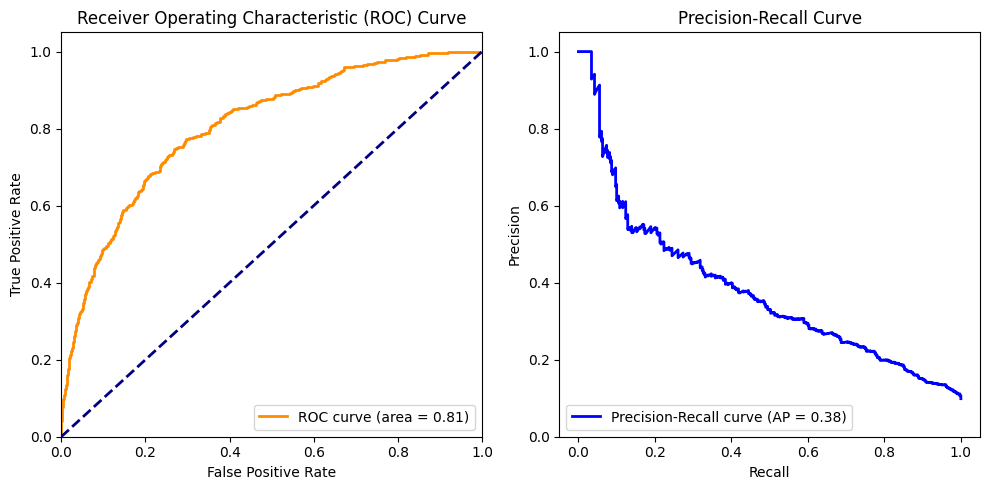

In [103]:
# plotting ROC and PR curve along with area under curves
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import numpy as np

# Get probability predictions for the positive class (class 1) using the best LightGBM model
lgb_model = optimized_model
y_prob = lgb_model.predict_proba(X_test)[:, 1]

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# Plot Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_prob)
average_precision = average_precision_score(y_test, y_prob)

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label=f'Precision-Recall curve (AP = {average_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.ylim([0.0, 1.05])
plt.legend(loc="lower left")

plt.tight_layout()
plt.show()

### We have achieved a higher AUC of ROC but the Average Precision could not be imporved 

### There may not be a need for a strong model for this set of features, a simple linear model can perform well too

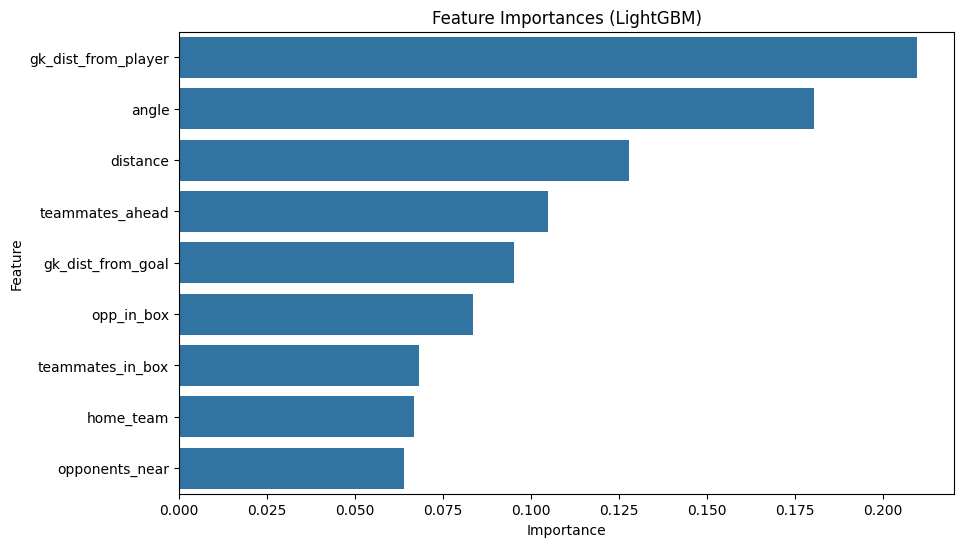

In [104]:
# Plot feature importances

feature_importance = pd.DataFrame({'feature': X_train.columns, 'importance': lgb_model.feature_importances_})
feature_importance = feature_importance.sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Feature Importances (LightGBM)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

In [105]:
import pickle

# Save the best model to a pickle file
filename = 'xgboost_model.pkl'
pickle.dump(optimized_model, open(filename, 'wb'))

print(f"Best model saved to {filename}")

Best model saved to xgboost_model.pkl
